<a href="https://colab.research.google.com/github/yousefhassan1999/Computer-Vision---Asg-2/blob/main/Computer_Vision_Asg_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Part 2: Image Mosaics

In [ ]:
%%shell
gdown 1ke_AsrHndOMtauGlMwp2CqRq85SBhDKU
gdown 1yA-nuD5juYRDm_eHQ4XI4odIXahqazRS

Downloading...
From: https://drive.google.com/uc?id=1ke_AsrHndOMtauGlMwp2CqRq85SBhDKU
To: /content/pano_image1.jpg
100% 190k/190k [00:00<00:00, 59.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yA-nuD5juYRDm_eHQ4XI4odIXahqazRS
To: /content/pano_image2.jpg
100% 191k/191k [00:00<00:00, 32.5MB/s]


In [ ]:
def plt_imgs(imgs, labels, figsize=(16, 9), cmap = None):
  assert len(imgs) == len(labels) and len(imgs) > 0
  
  fig, ax = plt.subplots(1, len(imgs), constrained_layout=False, figsize=figsize)
  for i in range(len(imgs)):
    curr_ax = ax[i] if len(imgs) > 1 else ax
    curr_ax.axis('off')
    curr_ax.imshow(imgs[i], cmap)
    curr_ax.set_title(labels[i])
  
  plt.show()

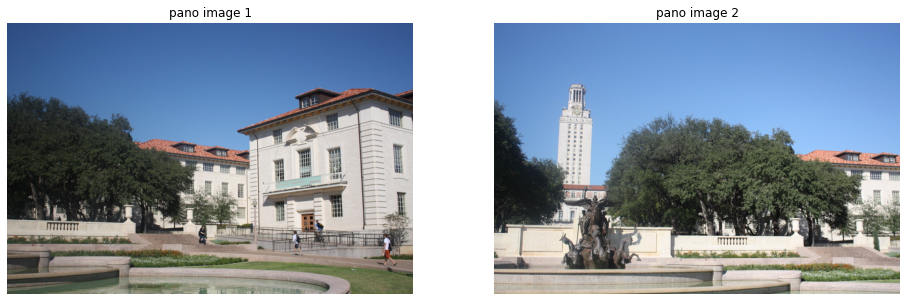

In [ ]:
img1 = cv2.cvtColor(cv2.imread('pano_image1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('pano_image2.jpg'), cv2.COLOR_BGR2RGB)

img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

plt_imgs([img1, img2], ["pano image 1", "pano image 2"])

### Correspondences

In [ ]:
def find_correspondences(disc1, disc2, k=2, ratio=0.75):
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  knn_result = bf.knnMatch(disc1, disc2, 2)

  final_result = []
  for c1, c2 in knn_result:
    if c1.distance < c2.distance * ratio:
      final_result.append(c1)

  return final_result

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
(pts1, disc1) = sift.detectAndCompute(img1, None)
(pts2, disc2) = sift.detectAndCompute(img2, None)

corr = find_correspondences(disc1, disc2)
print("Number of correspondences:", len(corr))

Number of correspondences: 1063


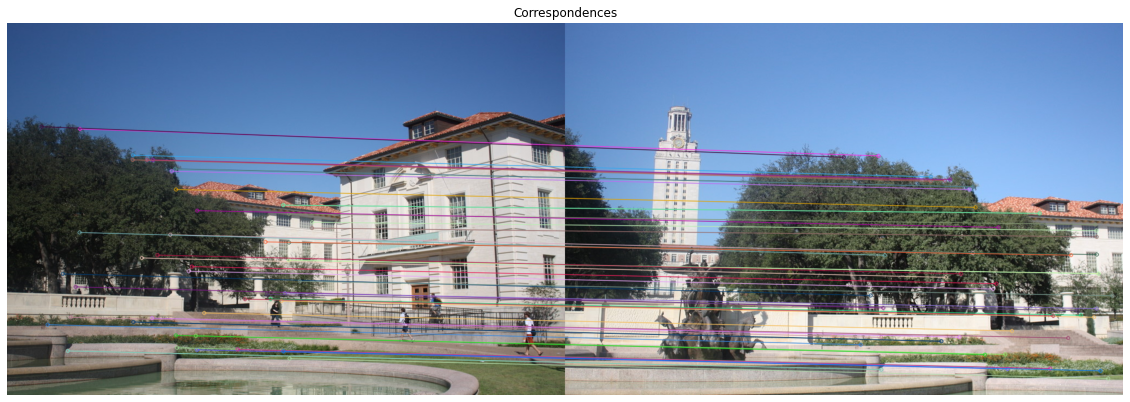

In [ ]:
corr_img = cv2.drawMatches(img1, pts1, img2, pts2, 
                           np.random.choice(corr, 50), None, 
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt_imgs([corr_img], ["Correspondences"], (20, 10))

### Homography Matrix

#### Built-in

In [ ]:
def homography_matrix(kpts1, kpts2, corr, reprojThresh):
  assert len(corr) > 4, "At least 4 correspondences needed"

  kpts1 = np.float32([kp.pt for kp in kpts1])
  kpts2 = np.float32([kp.pt for kp in kpts2])
    
  ptsA = np.float32([kpts1[c.queryIdx] for c in corr])
  ptsB = np.float32([kpts2[c.trainIdx] for c in corr])
  
  (homo_matrix, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

  return homo_matrix

In [ ]:
H = homography_matrix(pts1, pts2, corr, reprojThresh=4)
print(H)

[[ 7.64636107e-01  3.73045327e-02  4.46518787e+02]
 [-1.35738009e-01  9.11126930e-01  7.63258712e+01]
 [-2.11687897e-04 -3.29079113e-05  1.00000000e+00]]


#### Implemented

In [ ]:
##### Random Sample Consensus (RANSAC) Algorithm:
# 1. Randomly choose s samples. Typically s is the minimum samples to fit a model. For homography: s = 4 points

# 2. Fit the model to the randomly chosen samples.

# 3. Count the number M of data points (inliers) that the model within a measure of error ε.

# 4. Repeat Steps 1-3 N times, until the best model is found with high confidence

# 5. Choose the model that has the largest number of inliers.

def Homography_RANSAC(locs1, locs2,p=0.99,threshold=10):

	# Swap columns in locs because they are in the form of [y, x] returned by matchPics
	locs1 = np.fliplr(locs1)
	locs2 = np.fliplr(locs2)
	
	N = np.inf
	sample_count = 0
	max_num_inliers = 0

	while N > sample_count:#  4. Repeat Steps 1-3 N times, until the best model is found with high confidence

	# 1. Randomly choose s samples. Typically s is the minimum samples to fit a model. For homography: s = 4 points
		r = np.random.choice(len(locs1), 4)
		random_pts_1 =  np.asarray([locs1[i] for i in r], dtype=np.float32)
		random_pts_2 = np.asarray([locs2[i] for i in r], dtype=np.float32)
	
	# 2. Fit the model to the randomly chosen samples.
		H = computeH(random_pts_1, random_pts_2)
	

	# 3. Count the number M of data points (inliers) that the model within a measure of error ε.
		inlier_count = 0
		inliers = []
		for p1, p2 in zip(locs1, locs2):#for every two corresponding points

			# Convert to homogeneous coordinates   p = [x y 1]T
			p_homogeneous = (np.append(p2, 1)).reshape(3, 1) 
			# Multiply by the homography matrix    p' = H.P
			p_dash = H @ p_homogeneous
			# Convert back to heterogeneous coordinates   p' = [x' y' w']T   =>  p'=[x'/w'  y'/w']T
			p_dash = (p_dash/p_dash[2])[:2].reshape(1, 2)
			
			# calculate euclidean distance between the two points (the point the model gave and the actual point) 
			if cv2.norm(p1 - p_dash) <= threshold:
				inlier_count += 1
				inliers.append(1)
			else:
				inliers.append(0)
		
	# 5. Choose the model that has the largest number of inliers.
		if inlier_count > max_num_inliers:  
			max_num_inliers = inlier_count
			bestH = H
			inliers.append(p1)

		inlier_ratio = inlier_count / len(locs2)
		if np.log(1 - (inlier_ratio**8)) == 0:
			continue
		
		N = np.log(1-p) / np.log(1 - (inlier_ratio**8))
		sample_count += 1

	return bestH, inliers

def computeH(x1, x2):
	#Compute the homography between two sets of points
	A = []
	for i in range(len(x1)):
		x2_1, y2_2 = x2[i][0], x2[i][1]
		x1_1, y1_2 = x1[i][0], x1[i][1]
		A.append([x2_1, y2_2, 1, 0, 0, 0, -x1_1 * x2_1, -x1_1 * y2_2, -x1_1])
		A.append([0, 0 , 0, x2_1, y2_2, 1, -y1_2 * x2_1, -y1_2 * y2_2, -y1_2])
    
	A = np.array(A)
	U, D, V_t = np.linalg.svd(A)
    # the solution will be the last column (the eigenvector corresponding to the smallest eigenvalue) of the orthonormal matrix 
		# normalize by dividing by the element at (3,3) W 
	H = np.reshape(V_t[-1, :], (3, 3))
	return H


def compositeH(H2to1, template, img):
	#Create a composite image after warping the template image on top of the image using the homography

	#For warping the template to the image, we need to invert it.
	H_inv = np.linalg.pinv(H2to1)

	#Create mask of same size as template
	mask = np.ones(template.shape)
 
	#Warp mask by appropriate homography
	mask_warp = cv2.warpPerspective(mask, H_inv, (img.shape[1], img.shape[0]))
 
	#Warp template by appropriate homography
	template_warp = cv2.warpPerspective(template, H_inv, (img.shape[1], img.shape[0]))
 
	#Use mask to combine the warped template and the image
	composite_img = template_warp + img * np.logical_not(mask_warp)
 
	return composite_img

In [ ]:
locs1=[]
for x in pts1:
  locs1.append([x.pt[1] , x.pt[0]])
locs1 = np.asarray(locs1)

locs2=[]
for x in pts2:
  locs2.append([x.pt[1] , x.pt[0]])
locs2 = np.asarray(locs2)

# print(locs1)
matches = find_correspondences(disc1, disc2)

matchesPos=[]
for x in matches:
  matchesPos.append([x.queryIdx , x.trainIdx])
matchesPos = np.asarray(matchesPos)

bestH, _ = Homography_RANSAC(locs2[matchesPos[:, 1]], locs1[matchesPos[:, 0]])
bestH /= bestH[2, 2]
print(bestH)

[[ 7.50811401e-01  4.50817413e-02  4.51940458e+02]
 [-1.44683742e-01  9.28038961e-01  7.44649179e+01]
 [-2.31109119e-04 -5.93162755e-06  1.00000000e+00]]


### Warping and Stitching

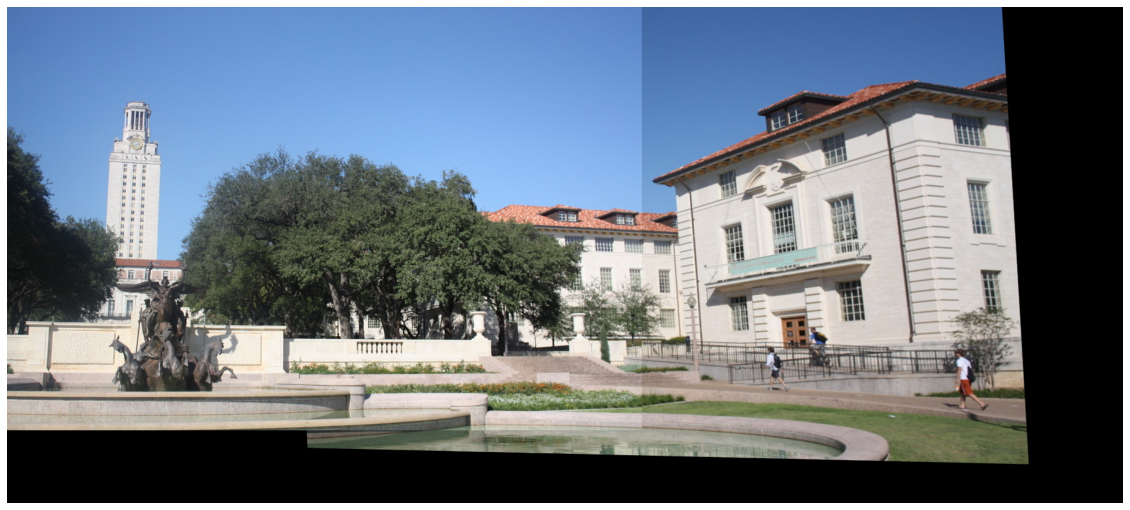

In [ ]:
w = 1800
h = 800

result = cv2.warpPerspective(img1, H, (w, h))
result[0:img2.shape[0], 0:img2.shape[1]] = img2

plt_imgs([result], [""], (20, 10))

In [ ]:
from math import inf, ceil, floor

def weighted_inter(img, x, y):
  h, w, _ = img.shape
  t, d = (floor(y), ceil(y))
  l, r = (floor(x), ceil(x))

  valid_t = t >= 0 and t < h
  valid_d = d >= 0 and d < h
  valid_l = l >= 0 and l < w
  valid_r = r >= 0 and r < w

  I_tl = img[t, l, :] if valid_t and valid_l else 0
  I_tr = img[t, r, :] if valid_t and valid_r else 0
  I_dl = img[d, l, :] if valid_d and valid_l else 0
  I_dr = img[d, r, :] if valid_d and valid_r else 0

  return abs(y - t) * abs(x - l) * I_dr\
        + abs(y - t) * abs(x - r) * I_dl\
        + abs(y - d) * abs(x - l) * I_tr\
        + abs(y - d) * abs(x - r) * I_tl

def nearest_inter(img, x, y):
  h, w, _ = img.shape
  n_x, n_y = round(x), round(y)
  return img[n_y, n_x, :] if n_y >= 0 and n_y < h and n_x >= 0 and n_x < w else 0

In [ ]:
def point(x, y):
  return np.array([x,y,1]).reshape((3, 1))

def warpPerspective(img, H):
  minX, minY, maxX, maxY = (inf, inf, -inf, -inf)
  for y in [0, img.shape[0] - 1]:
    for x in [0, img.shape[1] - 1]:
      P = H @ point(x, y)
      P = P / P[2]
      minX, minY = (min(minX, P[0].item()), min(minY, P[1].item()))
      maxX, maxY = (max(maxX, P[0].item()), max(maxY, P[1].item()))
  

  if(len(img.shape) == 2): 
    img = img.reshape(img.shape + (-1,))
  warpedImg = np.zeros((ceil(maxY - minY), ceil(maxX - minX), img.shape[2]), dtype=np.ubyte)

  # Forward Warping
  # for y in range(img.shape[0]):
  #   for x in range(img.shape[1]):
  #     P = H @ point(x, y)
  #     P = P / P[2]
  #     warpedImg[int(P[1] - minY), int(P[0] - minX)] = img[y, x]

  # Inverse Warping
  H_inv = np.linalg.inv(H)
  for y in range(warpedImg.shape[0]):
    for x in range(warpedImg.shape[1]):
      P = H_inv @ point(x + minX, y + minY)
      P = (P / P[2]).reshape(-1)
      warpedImg[y, x, :] = weighted_inter(img, P[0], P[1])
  
  if warpedImg.shape[2] == 1:
    warpedImg = warpedImg.reshape(warpedImg.shape[0], -1)
  
  return warpedImg, minX, minY

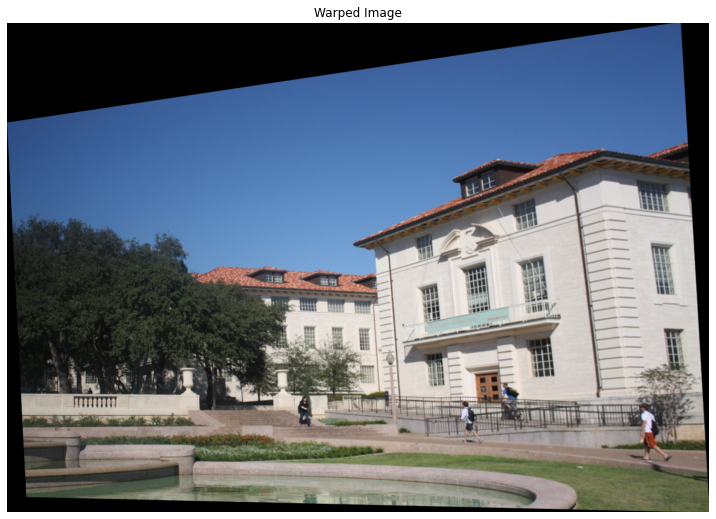

In [ ]:
warped, marginX, marginY = warpPerspective(img1, H)
plt_imgs([warped], ["Warped Image"])

In [ ]:
def stitch(src_img, warped, marginX, marginY):
  h = max(src_img.shape[0], warped.shape[0], ceil(src_img.shape[0] - marginY), ceil(warped.shape[0] + marginY))
  w = max(src_img.shape[1], warped.shape[1], ceil(src_img.shape[1] - marginX), ceil(warped.shape[1] + marginX))
  result = np.zeros((h, w, 3), dtype=np.ubyte)

  marX, marY = max(0, round(marginX)), max(0, round(marginY))
  result[marY:marY+warped.shape[0], marX:marX+warped.shape[1]] = warped

  marX, marY = max(0, round(-marginX)), max(0, round(-marginY))
  result[marY:marY+src_img.shape[0], marX:marX+src_img.shape[1]] = src_img

  return result

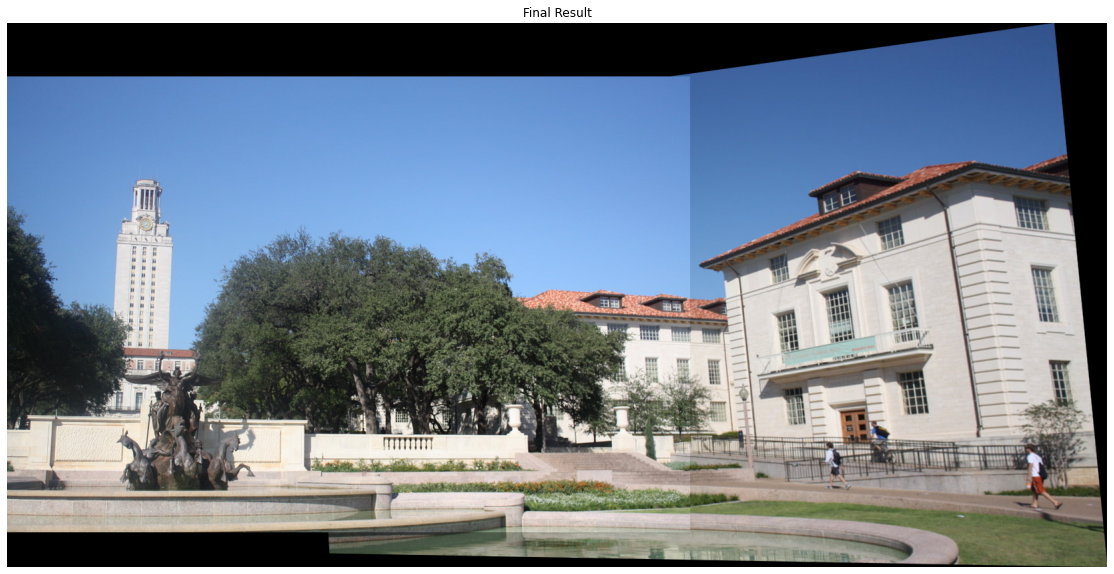

In [ ]:
result = stitch(img2, warped, marginX, marginY)
plt_imgs([result], ["Final Result"], (20, 10))

### Everything together in one method

In [ ]:
def stitch_images(src_img, to_warp_img):
  img1_gray = cv2.cvtColor(to_warp_img, cv2.COLOR_RGB2GRAY)
  img2_gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  (pts1, disc1) = sift.detectAndCompute(img1_gray, None)
  (pts2, disc2) = sift.detectAndCompute(img2_gray, None)

  corr = find_correspondences(disc1, disc2)
  H = homography_matrix(pts1, pts2, corr, reprojThresh=4)
  warped, marginX, marginY = warpPerspective(to_warp_img, H)

  result = stitch(src_img, warped, marginX, marginY)
  
  return result

### Three Images

In [ ]:
%%shell
gdown 1pao2gTApogHqQj0rTLd3U_ORksloyTpD
gdown 1htnzjaEJRimnRfSFj81oW-xaJQUR1tDq
gdown 1NTvAfeEZ2WlR8mBSEY-djCC9Qp3pvRHW

Downloading...
From: https://drive.google.com/uc?id=1pao2gTApogHqQj0rTLd3U_ORksloyTpD
To: /content/shanghai-21.png
100% 232k/232k [00:00<00:00, 58.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1htnzjaEJRimnRfSFj81oW-xaJQUR1tDq
To: /content/shanghai-22.png
100% 201k/201k [00:00<00:00, 92.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NTvAfeEZ2WlR8mBSEY-djCC9Qp3pvRHW
To: /content/shanghai-23.png
100% 246k/246k [00:00<00:00, 99.4MB/s]


In [ ]:
shanghai21 = cv2.cvtColor(cv2.imread('shanghai-21.png'), cv2.COLOR_BGR2RGB)
shanghai22 = cv2.cvtColor(cv2.imread('shanghai-22.png'), cv2.COLOR_BGR2RGB)
shanghai23 = cv2.cvtColor(cv2.imread('shanghai-23.png'), cv2.COLOR_BGR2RGB)

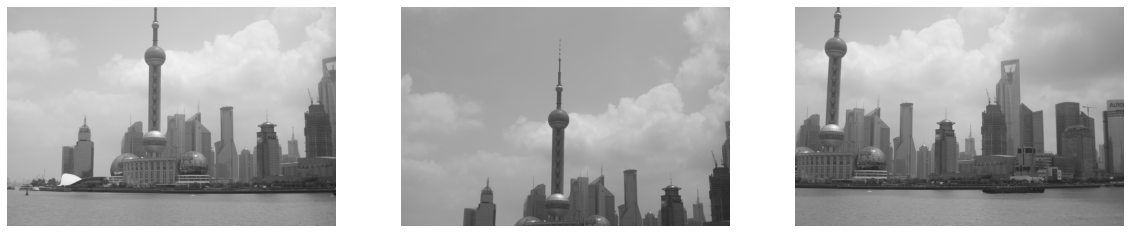

In [ ]:
plt_imgs([shanghai21, shanghai22, shanghai23], [""]*3, (20, 10))

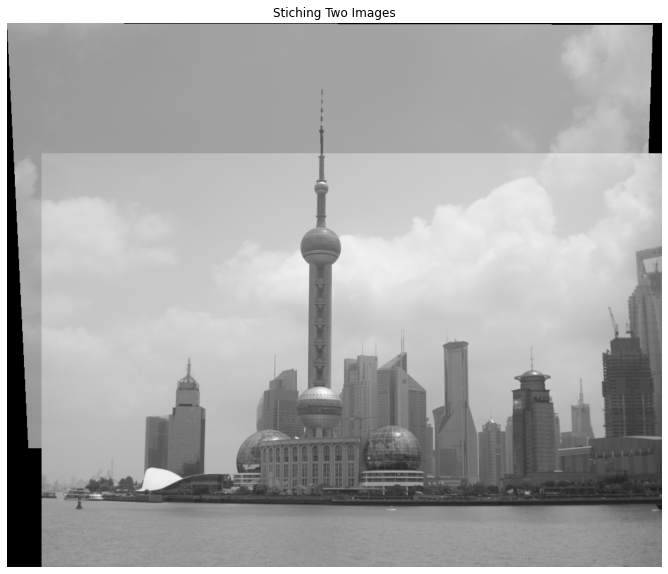

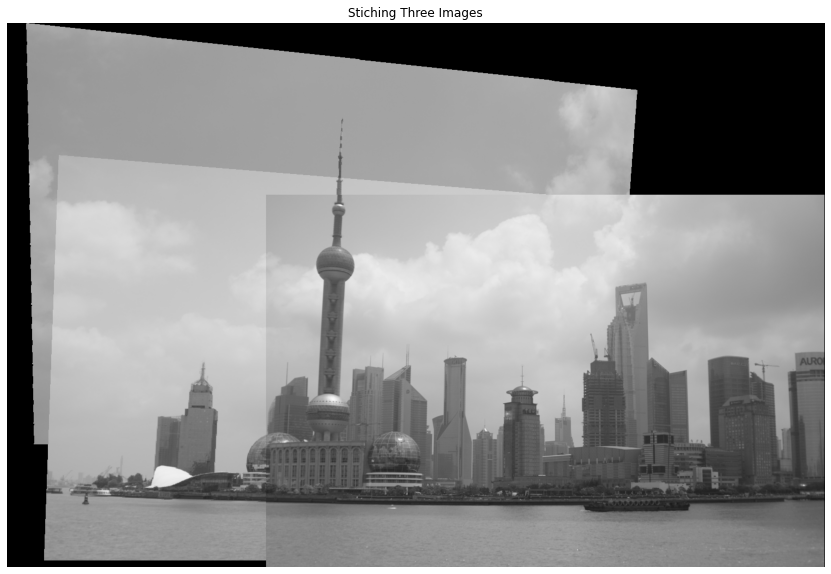

In [ ]:
shanghai_out1 = stitch_images(shanghai21, shanghai22)
plt_imgs([shanghai_out1], ["Stiching Two Images"], (20, 10))

shanghai_out2 = stitch_images(shanghai23, shanghai_out1)
plt_imgs([shanghai_out2], ["Stiching Three Images"], (20, 10))